<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-8i1_yu6g
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-8i1_yu6g
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 174 kB 65.2 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 42.9 MB/s 
     |██████

In [1]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
from finrl.finrl_meta.data_processors.processor_alpaca import AlpacaProcessor
from finrl.finrl_meta.data_processors.processor_wrds import WrdsProcessor
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_conservative import StockTradingEnvCon
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot2 import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [3]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE

'2014-01-01'

In [4]:
# from config.py TRAIN_END_DATE is a string
# config.TRAIN_END_DATE
# df2=TushareDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [5]:
# df = YahooDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [6]:
# print(config_tickers.DOW_30_TICKER)

In [7]:
df=pd.read_csv('./1.csv')
df.shape

(94360, 9)

In [8]:
df.sort_values(['date','tic'],ignore_index=True).head()

,Unnamed: 0,date,open,high,low,close,volume,tic,day
0,0,2008-12-31,3.070357,3.133571,3.047857,2.606277,607541200,AAPL,2
1,1,2008-12-31,57.110001,58.220001,57.060001,43.924454,6287200,AMGN,2
2,2,2008-12-31,17.969999,18.750000,17.910000,14.908465,9625600,AXP,2
3,3,2008-12-31,41.590000,43.049999,41.500000,32.005894,5443100,BA,2
4,4,2008-12-31,43.700001,45.099998,43.700001,30.628819,6277400,CAT,2


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [9]:
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     tech_indicator_list = config.INDICATORS,
#                     use_vix=True,
#                     use_turbulence=True,
#                     user_defined_feature = False)

# processed = fe.preprocess_data(df)

In [10]:
# list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

# processed_full = processed_full.fillna(0)

In [11]:
processed_full=pd.read_csv('./2.csv')
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.606277,607541200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,2.606277,2.606277,40.0,0.0
1,1,2008-12-31,AMGN,57.110001,58.220001,57.060001,43.924454,6287200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.924454,43.924454,40.0,0.0
2,2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.908465,9625600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,14.908465,14.908465,40.0,0.0
3,3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005894,5443100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,32.005894,32.005894,40.0,0.0
4,4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.628819,6277400.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,30.628819,30.628819,40.0,0.0
5,5,2008-12-31,CRM,7.712500,8.130000,7.707500,8.002500,5367600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,8.002500,8.002500,40.0,0.0
6,6,2008-12-31,CSCO,16.180000,16.549999,16.120001,11.787783,37513700.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,11.787783,11.787783,40.0,0.0
7,7,2008-12-31,CVX,72.900002,74.629997,72.900002,43.314438,9964300.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.314438,43.314438,40.0,0.0
8,8,2008-12-31,DIS,22.570000,22.950001,22.520000,19.538342,9012100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,19.538342,19.538342,40.0,0.0
9,9,2008-12-31,GS,82.239998,86.150002,81.120003,69.224182,14894100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,69.224182,69.224182,40.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [12]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [13]:
train.tail()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,121795,2020-06-30,UNH,288.570007,296.450012,287.660004,287.776794,2932900.0,1.0,-0.019475,303.925869,271.251255,52.413046,-25.838431,1.846804,288.020689,281.001438,30.43,12.918751
2892,121796,2020-06-30,V,191.490005,193.750000,190.160004,190.737244,9040100.0,1.0,1.048786,198.750528,185.041391,53.021033,-51.550760,2.013358,191.485037,181.677683,30.43,12.918751
2892,121797,2020-06-30,VZ,54.919998,55.290001,54.360001,50.376743,17414800.0,1.0,-0.437111,53.918425,48.729324,48.097044,-51.018262,8.508886,51.012123,51.464679,30.43,12.918751
2892,121798,2020-06-30,WBA,42.119999,42.580002,41.759998,39.035732,4782100.0,1.0,-0.083986,42.609305,36.487095,48.830181,-14.508130,1.500723,39.135190,38.935129,30.43,12.918751
2892,121799,2020-06-30,WMT,119.220001,120.129997,118.540001,116.121765,6836400.0,1.0,-0.886569,119.473758,113.510454,48.159665,-69.938795,3.847271,117.787627,119.723273,30.43,12.918751


In [14]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [15]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [16]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [17]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

e_train_gym_conservative = StockTradingEnvCon(df = train, **env_kwargs)
e_train_gym_conservative.value_history.shape

(20,)

## Environment for Training



In [18]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
env_train_con, _ = e_train_gym_conservative.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [19]:
agent = DRLAgent(env = env_train)
agent_con = DRLAgent(env = env_train_con)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [62]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 67         |
|    iterations         | 100        |
|    time_elapsed       | 7          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -1.41      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -72.8      |
|    reward             | 0.19451597 |
|    std                | 1          |
|    value_loss         | 3.68       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 68         |
|    iterations         | 200        |
|    time_elapsed       | 14         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -0.115     |
|    learning_rate      |

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 1500      |
|    time_elapsed       | 108       |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -39.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | 169       |
|    reward             | 4.8591986 |
|    std                | 1.01      |
|    value_loss         | 21.7      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 1600       |
|    time_elapsed       | 115        |
|    total_timesteps    | 8000       |
| train/                |            |
|    entropy_loss       | -40        |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 2900      |
|    time_elapsed       | 209       |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -40.1     |
|    explained_variance | 0.88      |
|    learning_rate      | 0.0007    |
|    n_updates          | 2899      |
|    policy_loss        | -116      |
|    reward             | 2.3091433 |
|    std                | 1.01      |
|    value_loss         | 9.5       |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 3000       |
|    time_elapsed       | 216        |
|    total_timesteps    | 15000      |
| train/                |            |
|    entropy_loss       | -40.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 4300      |
|    time_elapsed       | 309       |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -40.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 4299      |
|    policy_loss        | -64       |
|    reward             | 3.9822705 |
|    std                | 1.02      |
|    value_loss         | 3.59      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 4400       |
|    time_elapsed       | 317        |
|    total_timesteps    | 22000      |
| train/                |            |
|    entropy_loss       | -40.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 5600        |
|    time_elapsed       | 403         |
|    total_timesteps    | 28000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 5599        |
|    policy_loss        | -46.9       |
|    reward             | -0.06746031 |
|    std                | 1.02        |
|    value_loss         | 3.12        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 5700       |
|    time_elapsed       | 411        |
|    total_timesteps    | 28500      |
| train/                |            |
|    entropy_loss       | -40.3      |
|    explained_variance | 0.00117    |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7000       |
|    time_elapsed       | 504        |
|    total_timesteps    | 35000      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 6999       |
|    policy_loss        | 72.3       |
|    reward             | 0.22214015 |
|    std                | 1.03       |
|    value_loss         | 3.11       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7100       |
|    time_elapsed       | 511        |
|    total_timesteps    | 35500      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 0          |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 8400        |
|    time_elapsed       | 605         |
|    total_timesteps    | 42000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 8399        |
|    policy_loss        | -214        |
|    reward             | -0.94865924 |
|    std                | 1.03        |
|    value_loss         | 30.5        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 8500      |
|    time_elapsed       | 613       |
|    total_timesteps    | 42500     |
| train/                |           |
|    entropy_loss       | -40.4     |
|    explained_variance | 0         |
|    learning_rate

------------------------------------
| time/                 |          |
|    fps                | 69       |
|    iterations         | 9800     |
|    time_elapsed       | 706      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -40.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 177      |
|    reward             | 8.957433 |
|    std                | 1.04     |
|    value_loss         | 58.6     |
------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 9900        |
|    time_elapsed       | 714         |
|    total_timesteps    | 49500       |
| train/                |             |
|    entropy_loss       | -40.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_u

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3: PPO

In [19]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [30]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name="1",
                             total_timesteps=3000000)

Logging to ppo/1_1
----------------------------------
| time/              |           |
|    fps             | 124       |
|    iterations      | 1         |
|    time_elapsed    | 16        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.5073655 |
----------------------------------
day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3946387.70
total_reward: 2946387.70
total_cost: 357438.48
total_trades: 81024
Sharpe: 0.793
-----------------------------------------
| time/                   |             |
|    fps                  | 120         |
|    iterations           | 2           |
|    time_elapsed         | 34          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015788507 |
|    clip_fraction        | 0.214       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00723     |


KeyboardInterrupt: 

### Model 4: TD3

In [19]:
agent_con = DRLAgent(env = env_train_con)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo2 = agent_con.get_model("ppo",model_kwargs = PPO_PARAMS,tensorboard_log='ppo')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [20]:
# model_ppo2.load('42')
print('load')
trained_ppo2 = agent_con.train_model(model=model_ppo2, 
                             tb_log_name="6",
                             total_timesteps=3000000)

load
Logging to ppo/6_2
-----------------------------------
| time/              |            |
|    fps             | 105        |
|    iterations      | 1          |
|    time_elapsed    | 19         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.31676605 |
-----------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 104       |
|    iterations           | 2         |
|    time_elapsed         | 39        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0199437 |
|    clip_fraction        | 0.266     |
|    clip_range           | 0.2       |
|    entropy_loss         | -41.2     |
|    explained_variance   | -0.00745  |
|    learning_rate        | 0.00025   |
|    loss                 | 14.7      |
|    n_updates            | 10        |
|    policy_gradient_loss | -0.0215   |
|    reward 

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 12          |
|    time_elapsed         | 243         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.017026192 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.7       |
|    explained_variance   | 0.0183      |
|    learning_rate        | 0.00025     |
|    loss                 | 13.4        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0242     |
|    reward               | 0.27372253  |
|    std                  | 1.02        |
|    value_loss           | 44.4        |
-----------------------------------------
day: 2892, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 4814169.16
total_reward: 3814169.16
total_cost: 342953.39
total_trades: 80367
Sharpe: 0.83

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 22          |
|    time_elapsed         | 450         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.021045096 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.2       |
|    explained_variance   | 0.018       |
|    learning_rate        | 0.00025     |
|    loss                 | 65.3        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00999    |
|    reward               | 3.7547123   |
|    std                  | 1.04        |
|    value_loss           | 105         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 23    

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 32          |
|    time_elapsed         | 657         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.012311785 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -0.0188     |
|    learning_rate        | 0.00025     |
|    loss                 | 25.3        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0112     |
|    reward               | -0.1830933  |
|    std                  | 1.05        |
|    value_loss           | 82.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 33    

----------------------------------------
| time/                   |            |
|    fps                  | 99         |
|    iterations           | 42         |
|    time_elapsed         | 866        |
|    total_timesteps      | 86016      |
| train/                  |            |
|    approx_kl            | 0.01357609 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -42.9      |
|    explained_variance   | 0.0948     |
|    learning_rate        | 0.00025    |
|    loss                 | 54.9       |
|    n_updates            | 410        |
|    policy_gradient_loss | -0.00633   |
|    reward               | 0.23454796 |
|    std                  | 1.06       |
|    value_loss           | 158        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 43          |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 52          |
|    time_elapsed         | 1074        |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.017782103 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.1       |
|    explained_variance   | 0.0566      |
|    learning_rate        | 0.00025     |
|    loss                 | 124         |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.0094     |
|    reward               | -7.1070743  |
|    std                  | 1.07        |
|    value_loss           | 404         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 53    

-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 62          |
|    time_elapsed         | 1282        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.014184408 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.188       |
|    learning_rate        | 0.00025     |
|    loss                 | 165         |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.00955    |
|    reward               | 8.209359    |
|    std                  | 1.08        |
|    value_loss           | 1.22e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 63    

----------------------------------------
| time/                   |            |
|    fps                  | 98         |
|    iterations           | 72         |
|    time_elapsed         | 1494       |
|    total_timesteps      | 147456     |
| train/                  |            |
|    approx_kl            | 0.02652251 |
|    clip_fraction        | 0.204      |
|    clip_range           | 0.2        |
|    entropy_loss         | -43.9      |
|    explained_variance   | 0.2        |
|    learning_rate        | 0.00025    |
|    loss                 | 905        |
|    n_updates            | 710        |
|    policy_gradient_loss | 0.00106    |
|    reward               | -21.828793 |
|    std                  | 1.1        |
|    value_loss           | 1.55e+03   |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 73          |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 82          |
|    time_elapsed         | 1701        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.020783808 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.4       |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.00025     |
|    loss                 | 252         |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.000911   |
|    reward               | -0.6363444  |
|    std                  | 1.12        |
|    value_loss           | 543         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 98         |
|    iterations           | 83       

----------------------------------------
| time/                   |            |
|    fps                  | 98         |
|    iterations           | 92         |
|    time_elapsed         | 1911       |
|    total_timesteps      | 188416     |
| train/                  |            |
|    approx_kl            | 0.03768009 |
|    clip_fraction        | 0.339      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.9      |
|    explained_variance   | 0.521      |
|    learning_rate        | 0.00025    |
|    loss                 | 46         |
|    n_updates            | 910        |
|    policy_gradient_loss | 0.000211   |
|    reward               | -1.118216  |
|    std                  | 1.14       |
|    value_loss           | 223        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 93          |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 102         |
|    time_elapsed         | 2121        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.023068406 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.4       |
|    explained_variance   | 0.248       |
|    learning_rate        | 0.00025     |
|    loss                 | 64          |
|    n_updates            | 1010        |
|    policy_gradient_loss | -0.012      |
|    reward               | -8.277229   |
|    std                  | 1.16        |
|    value_loss           | 148         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 103   

day: 2892, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 2935331.58
total_reward: 1935331.58
total_cost: 313732.73
total_trades: 74322
Sharpe: 0.575
---------------------------------------
| time/                   |           |
|    fps                  | 98        |
|    iterations           | 112       |
|    time_elapsed         | 2331      |
|    total_timesteps      | 229376    |
| train/                  |           |
|    approx_kl            | 0.0293299 |
|    clip_fraction        | 0.301     |
|    clip_range           | 0.2       |
|    entropy_loss         | -46       |
|    explained_variance   | 0.504     |
|    learning_rate        | 0.00025   |
|    loss                 | 32.5      |
|    n_updates            | 1110      |
|    policy_gradient_loss | -0.00809  |
|    reward               | -0.816224 |
|    std                  | 1.18      |
|    value_loss           | 92.3      |
---------------------------------------
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 122         |
|    time_elapsed         | 2549        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.030139036 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.3       |
|    explained_variance   | 0.42        |
|    learning_rate        | 0.00025     |
|    loss                 | 46          |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.00795    |
|    reward               | 0.6072077   |
|    std                  | 1.2         |
|    value_loss           | 188         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 97           |
|    iterations           | 123

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 132         |
|    time_elapsed         | 2766        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.029765278 |
|    clip_fraction        | 0.267       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.8       |
|    explained_variance   | 0.13        |
|    learning_rate        | 0.00025     |
|    loss                 | 14.9        |
|    n_updates            | 1310        |
|    policy_gradient_loss | -0.00921    |
|    reward               | 1.2063155   |
|    std                  | 1.22        |
|    value_loss           | 45.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 133   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 142         |
|    time_elapsed         | 2980        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.034151036 |
|    clip_fraction        | 0.298       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.3       |
|    explained_variance   | 0.571       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.7        |
|    n_updates            | 1410        |
|    policy_gradient_loss | -0.00293    |
|    reward               | -0.11099429 |
|    std                  | 1.24        |
|    value_loss           | 58.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 143   

----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 152        |
|    time_elapsed         | 3187       |
|    total_timesteps      | 311296     |
| train/                  |            |
|    approx_kl            | 0.02609342 |
|    clip_fraction        | 0.26       |
|    clip_range           | 0.2        |
|    entropy_loss         | -47.6      |
|    explained_variance   | 0.565      |
|    learning_rate        | 0.00025    |
|    loss                 | 112        |
|    n_updates            | 1510       |
|    policy_gradient_loss | 0.00566    |
|    reward               | -0.5369632 |
|    std                  | 1.25       |
|    value_loss           | 225        |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 153        |
|    time_elapse

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 162         |
|    time_elapsed         | 3395        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.042746622 |
|    clip_fraction        | 0.264       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.8       |
|    explained_variance   | 0.532       |
|    learning_rate        | 0.00025     |
|    loss                 | 100         |
|    n_updates            | 1610        |
|    policy_gradient_loss | -0.0069     |
|    reward               | -0.7367465  |
|    std                  | 1.26        |
|    value_loss           | 253         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 163   

------------------------------------------
| time/                   |              |
|    fps                  | 97           |
|    iterations           | 172          |
|    time_elapsed         | 3604         |
|    total_timesteps      | 352256       |
| train/                  |              |
|    approx_kl            | 0.0073821973 |
|    clip_fraction        | 0.0618       |
|    clip_range           | 0.2          |
|    entropy_loss         | -48.4        |
|    explained_variance   | 0.321        |
|    learning_rate        | 0.00025      |
|    loss                 | 143          |
|    n_updates            | 1710         |
|    policy_gradient_loss | -0.0047      |
|    reward               | 2.416269     |
|    std                  | 1.29         |
|    value_loss           | 803          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 97           |
|    iterat

---------------------------------------
| time/                   |           |
|    fps                  | 97        |
|    iterations           | 182       |
|    time_elapsed         | 3813      |
|    total_timesteps      | 372736    |
| train/                  |           |
|    approx_kl            | 0.0344595 |
|    clip_fraction        | 0.285     |
|    clip_range           | 0.2       |
|    entropy_loss         | -48.9     |
|    explained_variance   | 0.186     |
|    learning_rate        | 0.00025   |
|    loss                 | 81.8      |
|    n_updates            | 1810      |
|    policy_gradient_loss | -0.000919 |
|    reward               | -2.2123   |
|    std                  | 1.31      |
|    value_loss           | 294       |
---------------------------------------
day: 2892, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 3149667.97
total_reward: 2149667.97
total_cost: 295068.06
total_trades: 71237
Sharpe: 0.578
-------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 192         |
|    time_elapsed         | 4023        |
|    total_timesteps      | 393216      |
| train/                  |             |
|    approx_kl            | 0.019451631 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.4       |
|    explained_variance   | 0.285       |
|    learning_rate        | 0.00025     |
|    loss                 | 129         |
|    n_updates            | 1910        |
|    policy_gradient_loss | -0.00407    |
|    reward               | -2.0110607  |
|    std                  | 1.33        |
|    value_loss           | 270         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 193      

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 202         |
|    time_elapsed         | 4233        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.022346795 |
|    clip_fraction        | 0.276       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.8       |
|    explained_variance   | 0.109       |
|    learning_rate        | 0.00025     |
|    loss                 | 268         |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.00728    |
|    reward               | -20.779024  |
|    std                  | 1.35        |
|    value_loss           | 395         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 203   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 212         |
|    time_elapsed         | 4444        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.024430169 |
|    clip_fraction        | 0.182       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.3       |
|    explained_variance   | 0.221       |
|    learning_rate        | 0.00025     |
|    loss                 | 339         |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.00845    |
|    reward               | 0.18306465  |
|    std                  | 1.37        |
|    value_loss           | 965         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 213      

------------------------------------------
| time/                   |              |
|    fps                  | 97           |
|    iterations           | 222          |
|    time_elapsed         | 4651         |
|    total_timesteps      | 454656       |
| train/                  |              |
|    approx_kl            | 0.025478734  |
|    clip_fraction        | 0.224        |
|    clip_range           | 0.2          |
|    entropy_loss         | -50.7        |
|    explained_variance   | 0.108        |
|    learning_rate        | 0.00025      |
|    loss                 | 729          |
|    n_updates            | 2210         |
|    policy_gradient_loss | -0.00702     |
|    reward               | -0.029875671 |
|    std                  | 1.4          |
|    value_loss           | 1.36e+03     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 232         |
|    time_elapsed         | 4860        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.027491022 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51         |
|    explained_variance   | 0.413       |
|    learning_rate        | 0.00025     |
|    loss                 | 407         |
|    n_updates            | 2310        |
|    policy_gradient_loss | -0.00725    |
|    reward               | 0.37346026  |
|    std                  | 1.41        |
|    value_loss           | 481         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 233   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 242         |
|    time_elapsed         | 5066        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.023862459 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.5       |
|    explained_variance   | 0.287       |
|    learning_rate        | 0.00025     |
|    loss                 | 344         |
|    n_updates            | 2410        |
|    policy_gradient_loss | -0.0113     |
|    reward               | 3.353009    |
|    std                  | 1.44        |
|    value_loss           | 764         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 243   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 252         |
|    time_elapsed         | 5276        |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.035689436 |
|    clip_fraction        | 0.333       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52         |
|    explained_variance   | 0.213       |
|    learning_rate        | 0.00025     |
|    loss                 | 78.8        |
|    n_updates            | 2510        |
|    policy_gradient_loss | -0.0103     |
|    reward               | -1.1353828  |
|    std                  | 1.46        |
|    value_loss           | 130         |
-----------------------------------------
day: 2892, episode: 180
begin_total_asset: 1000000.00
end_total_asset: 9922193.64
total_reward: 8922193.64
total_cost: 291991.84
total_trades: 68450
Sharpe: 1.1

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 262         |
|    time_elapsed         | 5488        |
|    total_timesteps      | 536576      |
| train/                  |             |
|    approx_kl            | 0.043404605 |
|    clip_fraction        | 0.367       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.6       |
|    explained_variance   | 0.0593      |
|    learning_rate        | 0.00025     |
|    loss                 | 29.7        |
|    n_updates            | 2610        |
|    policy_gradient_loss | -0.00428    |
|    reward               | 1.8311363   |
|    std                  | 1.49        |
|    value_loss           | 70.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 263   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 272         |
|    time_elapsed         | 5698        |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.030964002 |
|    clip_fraction        | 0.277       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.9       |
|    explained_variance   | 0.197       |
|    learning_rate        | 0.00025     |
|    loss                 | 73.6        |
|    n_updates            | 2710        |
|    policy_gradient_loss | -0.00873    |
|    reward               | -14.590688  |
|    std                  | 1.51        |
|    value_loss           | 142         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 273      

day: 2892, episode: 200
begin_total_asset: 1000000.00
end_total_asset: 7882054.52
total_reward: 6882054.52
total_cost: 229157.36
total_trades: 64979
Sharpe: 1.010
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 282         |
|    time_elapsed         | 5904        |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.020309204 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.5       |
|    explained_variance   | 0.685       |
|    learning_rate        | 0.00025     |
|    loss                 | 89.2        |
|    n_updates            | 2810        |
|    policy_gradient_loss | -0.0073     |
|    reward               | -0.7211929  |
|    std                  | 1.54        |
|    value_loss           | 189         |
---------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 292        |
|    time_elapsed         | 6112       |
|    total_timesteps      | 598016     |
| train/                  |            |
|    approx_kl            | 0.02214507 |
|    clip_fraction        | 0.234      |
|    clip_range           | 0.2        |
|    entropy_loss         | -54        |
|    explained_variance   | 0.0863     |
|    learning_rate        | 0.00025    |
|    loss                 | 450        |
|    n_updates            | 2910       |
|    policy_gradient_loss | -0.011     |
|    reward               | 2.2734435  |
|    std                  | 1.56       |
|    value_loss           | 707        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 293         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 302         |
|    time_elapsed         | 6324        |
|    total_timesteps      | 618496      |
| train/                  |             |
|    approx_kl            | 0.021372722 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.4       |
|    explained_variance   | 0.728       |
|    learning_rate        | 0.00025     |
|    loss                 | 79.6        |
|    n_updates            | 3010        |
|    policy_gradient_loss | 0.0083      |
|    reward               | -8.861511   |
|    std                  | 1.58        |
|    value_loss           | 289         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 303   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 312         |
|    time_elapsed         | 6537        |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.017201547 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.8       |
|    explained_variance   | 0.376       |
|    learning_rate        | 0.00025     |
|    loss                 | 185         |
|    n_updates            | 3110        |
|    policy_gradient_loss | -0.00197    |
|    reward               | -1.4521217  |
|    std                  | 1.6         |
|    value_loss           | 584         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 313   

----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 322        |
|    time_elapsed         | 6745       |
|    total_timesteps      | 659456     |
| train/                  |            |
|    approx_kl            | 0.03212752 |
|    clip_fraction        | 0.221      |
|    clip_range           | 0.2        |
|    entropy_loss         | -55.5      |
|    explained_variance   | 0.395      |
|    learning_rate        | 0.00025    |
|    loss                 | 205        |
|    n_updates            | 3210       |
|    policy_gradient_loss | -0.00781   |
|    reward               | 1.1216452  |
|    std                  | 1.65       |
|    value_loss           | 294        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 323         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 332         |
|    time_elapsed         | 6958        |
|    total_timesteps      | 679936      |
| train/                  |             |
|    approx_kl            | 0.012769528 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56         |
|    explained_variance   | 0.269       |
|    learning_rate        | 0.00025     |
|    loss                 | 229         |
|    n_updates            | 3310        |
|    policy_gradient_loss | -0.0123     |
|    reward               | -0.12797153 |
|    std                  | 1.67        |
|    value_loss           | 447         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 333      

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 342         |
|    time_elapsed         | 7169        |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.022487588 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.4       |
|    explained_variance   | 0.524       |
|    learning_rate        | 0.00025     |
|    loss                 | 86.5        |
|    n_updates            | 3410        |
|    policy_gradient_loss | -0.00716    |
|    reward               | 0.21638545  |
|    std                  | 1.7         |
|    value_loss           | 137         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 343   

day: 2892, episode: 250
begin_total_asset: 1000000.00
end_total_asset: 5476290.47
total_reward: 4476290.47
total_cost: 301938.66
total_trades: 67453
Sharpe: 0.873
----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 352        |
|    time_elapsed         | 7378       |
|    total_timesteps      | 720896     |
| train/                  |            |
|    approx_kl            | 0.02115713 |
|    clip_fraction        | 0.211      |
|    clip_range           | 0.2        |
|    entropy_loss         | -56.8      |
|    explained_variance   | 0.421      |
|    learning_rate        | 0.00025    |
|    loss                 | 192        |
|    n_updates            | 3510       |
|    policy_gradient_loss | -0.00912   |
|    reward               | -1.4664168 |
|    std                  | 1.72       |
|    value_loss           | 381        |
----------------------------------------
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 362         |
|    time_elapsed         | 7587        |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.017144576 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -57.2       |
|    explained_variance   | 0.633       |
|    learning_rate        | 0.00025     |
|    loss                 | 144         |
|    n_updates            | 3610        |
|    policy_gradient_loss | -0.000703   |
|    reward               | 2.1284642   |
|    std                  | 1.75        |
|    value_loss           | 235         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 363   

---------------------------------------
| time/                   |           |
|    fps                  | 97        |
|    iterations           | 372       |
|    time_elapsed         | 7795      |
|    total_timesteps      | 761856    |
| train/                  |           |
|    approx_kl            | 0.0233876 |
|    clip_fraction        | 0.212     |
|    clip_range           | 0.2       |
|    entropy_loss         | -57.6     |
|    explained_variance   | 0.319     |
|    learning_rate        | 0.00025   |
|    loss                 | 181       |
|    n_updates            | 3710      |
|    policy_gradient_loss | -0.0146   |
|    reward               | 1.2175741 |
|    std                  | 1.78      |
|    value_loss           | 213       |
---------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 373         |
|    time_elapsed         | 7816

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 382         |
|    time_elapsed         | 8001        |
|    total_timesteps      | 782336      |
| train/                  |             |
|    approx_kl            | 0.05236458  |
|    clip_fraction        | 0.386       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58         |
|    explained_variance   | 0.107       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.8        |
|    n_updates            | 3810        |
|    policy_gradient_loss | -0.0107     |
|    reward               | -0.51875705 |
|    std                  | 1.8         |
|    value_loss           | 32.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 383      

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 392         |
|    time_elapsed         | 8210        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.038487755 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.4       |
|    explained_variance   | 0.0981      |
|    learning_rate        | 0.00025     |
|    loss                 | 18.3        |
|    n_updates            | 3910        |
|    policy_gradient_loss | -0.00874    |
|    reward               | -0.49113828 |
|    std                  | 1.82        |
|    value_loss           | 42.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 393   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 402         |
|    time_elapsed         | 8416        |
|    total_timesteps      | 823296      |
| train/                  |             |
|    approx_kl            | 0.026629258 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.6       |
|    explained_variance   | 0.641       |
|    learning_rate        | 0.00025     |
|    loss                 | 45.5        |
|    n_updates            | 4010        |
|    policy_gradient_loss | -0.000808   |
|    reward               | 1.2837683   |
|    std                  | 1.84        |
|    value_loss           | 102         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 403   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 412         |
|    time_elapsed         | 8626        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.021435685 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.2       |
|    explained_variance   | 0.603       |
|    learning_rate        | 0.00025     |
|    loss                 | 28.8        |
|    n_updates            | 4110        |
|    policy_gradient_loss | -0.000745   |
|    reward               | -0.12852786 |
|    std                  | 1.87        |
|    value_loss           | 54.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 413   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 422         |
|    time_elapsed         | 8836        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 0.016526457 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.7       |
|    explained_variance   | 0.57        |
|    learning_rate        | 0.00025     |
|    loss                 | 52.5        |
|    n_updates            | 4210        |
|    policy_gradient_loss | -0.0075     |
|    reward               | 0.45773807  |
|    std                  | 1.9         |
|    value_loss           | 65.2        |
-----------------------------------------
day: 2892, episode: 300
begin_total_asset: 1000000.00
end_total_asset: 3688156.79
total_reward: 2688156.79
total_cost: 297063.14
total_trades: 65278
Sharpe: 0.7

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 432         |
|    time_elapsed         | 9045        |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.029945586 |
|    clip_fraction        | 0.259       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.2       |
|    explained_variance   | 0.29        |
|    learning_rate        | 0.00025     |
|    loss                 | 57.3        |
|    n_updates            | 4310        |
|    policy_gradient_loss | 0.000822    |
|    reward               | -3.142678   |
|    std                  | 1.94        |
|    value_loss           | 102         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 433      

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 442         |
|    time_elapsed         | 9254        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.015628852 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.7       |
|    explained_variance   | 0.179       |
|    learning_rate        | 0.00025     |
|    loss                 | 142         |
|    n_updates            | 4410        |
|    policy_gradient_loss | -0.0074     |
|    reward               | -21.420435  |
|    std                  | 1.98        |
|    value_loss           | 378         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 443   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 452         |
|    time_elapsed         | 9462        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.024789538 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.2       |
|    explained_variance   | 0.753       |
|    learning_rate        | 0.00025     |
|    loss                 | 33.1        |
|    n_updates            | 4510        |
|    policy_gradient_loss | -0.00552    |
|    reward               | -6.6452236  |
|    std                  | 2.01        |
|    value_loss           | 82.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 453   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 462         |
|    time_elapsed         | 9671        |
|    total_timesteps      | 946176      |
| train/                  |             |
|    approx_kl            | 0.020747848 |
|    clip_fraction        | 0.21        |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.1       |
|    explained_variance   | 0.109       |
|    learning_rate        | 0.00025     |
|    loss                 | 47.1        |
|    n_updates            | 4610        |
|    policy_gradient_loss | -0.0161     |
|    reward               | -0.22822501 |
|    std                  | 2.07        |
|    value_loss           | 303         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 463      

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 472         |
|    time_elapsed         | 9880        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.021372952 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.8       |
|    explained_variance   | 0.0531      |
|    learning_rate        | 0.00025     |
|    loss                 | 201         |
|    n_updates            | 4710        |
|    policy_gradient_loss | -0.0109     |
|    reward               | -0.4294741  |
|    std                  | 2.12        |
|    value_loss           | 308         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 473   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 482         |
|    time_elapsed         | 10094       |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.010234163 |
|    clip_fraction        | 0.0806      |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.5       |
|    explained_variance   | 0.288       |
|    learning_rate        | 0.00025     |
|    loss                 | 114         |
|    n_updates            | 4810        |
|    policy_gradient_loss | -0.0128     |
|    reward               | 0.23973852  |
|    std                  | 2.17        |
|    value_loss           | 261         |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 97        |
|    iterations           | 483       |


-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 492         |
|    time_elapsed         | 10304       |
|    total_timesteps      | 1007616     |
| train/                  |             |
|    approx_kl            | 0.018091133 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.9       |
|    explained_variance   | 0.505       |
|    learning_rate        | 0.00025     |
|    loss                 | 137         |
|    n_updates            | 4910        |
|    policy_gradient_loss | -0.0127     |
|    reward               | 1.3680218   |
|    std                  | 2.2         |
|    value_loss           | 205         |
-----------------------------------------
day: 2892, episode: 350
begin_total_asset: 1000000.00
end_total_asset: 4132286.40
total_reward: 3132286.40
total_cost: 321635.20
total_trades: 60681
Sharpe: 0.8

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 502         |
|    time_elapsed         | 10515       |
|    total_timesteps      | 1028096     |
| train/                  |             |
|    approx_kl            | 0.021783521 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.3       |
|    explained_variance   | 0.54        |
|    learning_rate        | 0.00025     |
|    loss                 | 43.4        |
|    n_updates            | 5010        |
|    policy_gradient_loss | -0.0167     |
|    reward               | -1.0338112  |
|    std                  | 2.24        |
|    value_loss           | 94.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 503   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 512         |
|    time_elapsed         | 10722       |
|    total_timesteps      | 1048576     |
| train/                  |             |
|    approx_kl            | 0.020704176 |
|    clip_fraction        | 0.28        |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.8       |
|    explained_variance   | 0.166       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.4        |
|    n_updates            | 5110        |
|    policy_gradient_loss | -0.00953    |
|    reward               | -1.2598287  |
|    std                  | 2.27        |
|    value_loss           | 41.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 513   

day: 2892, episode: 370
begin_total_asset: 1000000.00
end_total_asset: 1902620.11
total_reward: 902620.11
total_cost: 298225.64
total_trades: 62403
Sharpe: 0.395
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 522         |
|    time_elapsed         | 10929       |
|    total_timesteps      | 1069056     |
| train/                  |             |
|    approx_kl            | 0.037671216 |
|    clip_fraction        | 0.34        |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.2       |
|    explained_variance   | 0.564       |
|    learning_rate        | 0.00025     |
|    loss                 | 20          |
|    n_updates            | 5210        |
|    policy_gradient_loss | -0.00466    |
|    reward               | 1.1902004   |
|    std                  | 2.31        |
|    value_loss           | 49          |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 532         |
|    time_elapsed         | 11138       |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.021947283 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.8       |
|    explained_variance   | 0.516       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.2        |
|    n_updates            | 5310        |
|    policy_gradient_loss | -0.00759    |
|    reward               | 0.018983211 |
|    std                  | 2.35        |
|    value_loss           | 41          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 533   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 542         |
|    time_elapsed         | 11355       |
|    total_timesteps      | 1110016     |
| train/                  |             |
|    approx_kl            | 0.032135144 |
|    clip_fraction        | 0.3         |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.4       |
|    explained_variance   | 0.011       |
|    learning_rate        | 0.00025     |
|    loss                 | 38.8        |
|    n_updates            | 5410        |
|    policy_gradient_loss | -0.00569    |
|    reward               | 5.821106    |
|    std                  | 2.4         |
|    value_loss           | 151         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 543   

----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 552        |
|    time_elapsed         | 11568      |
|    total_timesteps      | 1130496    |
| train/                  |            |
|    approx_kl            | 0.02259418 |
|    clip_fraction        | 0.226      |
|    clip_range           | 0.2        |
|    entropy_loss         | -66.8      |
|    explained_variance   | 0.14       |
|    learning_rate        | 0.00025    |
|    loss                 | 46.6       |
|    n_updates            | 5510       |
|    policy_gradient_loss | -0.0132    |
|    reward               | 0.1460516  |
|    std                  | 2.44       |
|    value_loss           | 81.6       |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 553        |
|    time_elapse

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 562         |
|    time_elapsed         | 11779       |
|    total_timesteps      | 1150976     |
| train/                  |             |
|    approx_kl            | 0.016569534 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.5       |
|    explained_variance   | 0.273       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.8        |
|    n_updates            | 5610        |
|    policy_gradient_loss | -0.0116     |
|    reward               | -1.7255049  |
|    std                  | 2.49        |
|    value_loss           | 89.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 563   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 572         |
|    time_elapsed         | 11991       |
|    total_timesteps      | 1171456     |
| train/                  |             |
|    approx_kl            | 0.017977215 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68         |
|    explained_variance   | 0.469       |
|    learning_rate        | 0.00025     |
|    loss                 | 33.7        |
|    n_updates            | 5710        |
|    policy_gradient_loss | -0.0101     |
|    reward               | -1.5229839  |
|    std                  | 2.53        |
|    value_loss           | 80.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 573   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 582         |
|    time_elapsed         | 12202       |
|    total_timesteps      | 1191936     |
| train/                  |             |
|    approx_kl            | 0.013811003 |
|    clip_fraction        | 0.0893      |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.3       |
|    explained_variance   | 0.607       |
|    learning_rate        | 0.00025     |
|    loss                 | 89.6        |
|    n_updates            | 5810        |
|    policy_gradient_loss | -0.00759    |
|    reward               | -9.507784   |
|    std                  | 2.57        |
|    value_loss           | 164         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 583   

day: 2892, episode: 420
begin_total_asset: 1000000.00
end_total_asset: 3338142.84
total_reward: 2338142.84
total_cost: 327428.23
total_trades: 65447
Sharpe: 0.679
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 592         |
|    time_elapsed         | 12415       |
|    total_timesteps      | 1212416     |
| train/                  |             |
|    approx_kl            | 0.024337396 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.8       |
|    explained_variance   | 0.428       |
|    learning_rate        | 0.00025     |
|    loss                 | 34.7        |
|    n_updates            | 5910        |
|    policy_gradient_loss | -0.0128     |
|    reward               | 0.029893791 |
|    std                  | 2.61        |
|    value_loss           | 145         |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 602         |
|    time_elapsed         | 12630       |
|    total_timesteps      | 1232896     |
| train/                  |             |
|    approx_kl            | 0.014590146 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.4       |
|    explained_variance   | 0.577       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.2        |
|    n_updates            | 6010        |
|    policy_gradient_loss | -0.00966    |
|    reward               | 1.5177045   |
|    std                  | 2.67        |
|    value_loss           | 86.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 603   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 612         |
|    time_elapsed         | 12857       |
|    total_timesteps      | 1253376     |
| train/                  |             |
|    approx_kl            | 0.016833216 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.1       |
|    explained_variance   | 0.197       |
|    learning_rate        | 0.00025     |
|    loss                 | 46.2        |
|    n_updates            | 6110        |
|    policy_gradient_loss | -0.0161     |
|    reward               | 3.4556487   |
|    std                  | 2.73        |
|    value_loss           | 164         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 613   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 622         |
|    time_elapsed         | 13070       |
|    total_timesteps      | 1273856     |
| train/                  |             |
|    approx_kl            | 0.011951229 |
|    clip_fraction        | 0.0883      |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.5       |
|    explained_variance   | 0.488       |
|    learning_rate        | 0.00025     |
|    loss                 | 53.2        |
|    n_updates            | 6210        |
|    policy_gradient_loss | -0.00933    |
|    reward               | 0.082524195 |
|    std                  | 2.77        |
|    value_loss           | 121         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 623   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 632         |
|    time_elapsed         | 13286       |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.015757378 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -71         |
|    explained_variance   | 0.149       |
|    learning_rate        | 0.00025     |
|    loss                 | 14          |
|    n_updates            | 6310        |
|    policy_gradient_loss | -0.00959    |
|    reward               | 0.044143774 |
|    std                  | 2.82        |
|    value_loss           | 32.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 633   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 642         |
|    time_elapsed         | 13494       |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.016635966 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.6       |
|    explained_variance   | 0.405       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.7        |
|    n_updates            | 6410        |
|    policy_gradient_loss | -0.0117     |
|    reward               | 1.4145514   |
|    std                  | 2.88        |
|    value_loss           | 26          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 643   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 652         |
|    time_elapsed         | 13705       |
|    total_timesteps      | 1335296     |
| train/                  |             |
|    approx_kl            | 0.018063368 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.6       |
|    explained_variance   | 0.026       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.8        |
|    n_updates            | 6510        |
|    policy_gradient_loss | -0.00957    |
|    reward               | 1.5300435   |
|    std                  | 2.98        |
|    value_loss           | 28.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 653   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 662         |
|    time_elapsed         | 13913       |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.018020902 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.3       |
|    explained_variance   | 0.0113      |
|    learning_rate        | 0.00025     |
|    loss                 | 26.2        |
|    n_updates            | 6610        |
|    policy_gradient_loss | -0.0144     |
|    reward               | 0.96751314  |
|    std                  | 3.05        |
|    value_loss           | 44.6        |
-----------------------------------------
day: 2892, episode: 470
begin_total_asset: 1000000.00
end_total_asset: 2659010.58
total_reward: 1659010.58
total_cost: 319527.28
total_trades: 58449
Sharpe: 0.6

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 672         |
|    time_elapsed         | 14124       |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.028254192 |
|    clip_fraction        | 0.202       |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.8       |
|    explained_variance   | 0.101       |
|    learning_rate        | 0.00025     |
|    loss                 | 45.7        |
|    n_updates            | 6710        |
|    policy_gradient_loss | -0.00543    |
|    reward               | -0.24865635 |
|    std                  | 3.1         |
|    value_loss           | 123         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 673   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 682         |
|    time_elapsed         | 14344       |
|    total_timesteps      | 1396736     |
| train/                  |             |
|    approx_kl            | 0.019361805 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.3       |
|    explained_variance   | 0.312       |
|    learning_rate        | 0.00025     |
|    loss                 | 33.7        |
|    n_updates            | 6810        |
|    policy_gradient_loss | -0.00935    |
|    reward               | 0.8926936   |
|    std                  | 3.16        |
|    value_loss           | 69.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 683   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 692         |
|    time_elapsed         | 14555       |
|    total_timesteps      | 1417216     |
| train/                  |             |
|    approx_kl            | 0.017426979 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.9       |
|    explained_variance   | 0.176       |
|    learning_rate        | 0.00025     |
|    loss                 | 82.5        |
|    n_updates            | 6910        |
|    policy_gradient_loss | -0.0102     |
|    reward               | 1.1545533   |
|    std                  | 3.22        |
|    value_loss           | 126         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 693   

----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 702        |
|    time_elapsed         | 14766      |
|    total_timesteps      | 1437696    |
| train/                  |            |
|    approx_kl            | 0.01565278 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.5      |
|    explained_variance   | 0.375      |
|    learning_rate        | 0.00025    |
|    loss                 | 32.2       |
|    n_updates            | 7010       |
|    policy_gradient_loss | -0.00932   |
|    reward               | 3.8600316  |
|    std                  | 3.29       |
|    value_loss           | 125        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 703         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 712         |
|    time_elapsed         | 14976       |
|    total_timesteps      | 1458176     |
| train/                  |             |
|    approx_kl            | 0.011374829 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.1       |
|    explained_variance   | 0.0631      |
|    learning_rate        | 0.00025     |
|    loss                 | 77.8        |
|    n_updates            | 7110        |
|    policy_gradient_loss | -0.0134     |
|    reward               | -0.10276954 |
|    std                  | 3.36        |
|    value_loss           | 90.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 713   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 722         |
|    time_elapsed         | 15188       |
|    total_timesteps      | 1478656     |
| train/                  |             |
|    approx_kl            | 0.004971839 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.5       |
|    explained_variance   | 0.41        |
|    learning_rate        | 0.00025     |
|    loss                 | 38.8        |
|    n_updates            | 7210        |
|    policy_gradient_loss | -0.00506    |
|    reward               | -1.0155675  |
|    std                  | 3.41        |
|    value_loss           | 128         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 723   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 732         |
|    time_elapsed         | 15397       |
|    total_timesteps      | 1499136     |
| train/                  |             |
|    approx_kl            | 0.012007183 |
|    clip_fraction        | 0.0944      |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.9       |
|    explained_variance   | 0.461       |
|    learning_rate        | 0.00025     |
|    loss                 | 50.8        |
|    n_updates            | 7310        |
|    policy_gradient_loss | -0.00896    |
|    reward               | -0.20878275 |
|    std                  | 3.46        |
|    value_loss           | 88.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 733   

----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 742        |
|    time_elapsed         | 15607      |
|    total_timesteps      | 1519616    |
| train/                  |            |
|    approx_kl            | 0.01233326 |
|    clip_fraction        | 0.112      |
|    clip_range           | 0.2        |
|    entropy_loss         | -77.4      |
|    explained_variance   | 0.286      |
|    learning_rate        | 0.00025    |
|    loss                 | 21.9       |
|    n_updates            | 7410       |
|    policy_gradient_loss | -0.0132    |
|    reward               | 0.18478252 |
|    std                  | 3.52       |
|    value_loss           | 65.3       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 743         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 752         |
|    time_elapsed         | 15822       |
|    total_timesteps      | 1540096     |
| train/                  |             |
|    approx_kl            | 0.007299762 |
|    clip_fraction        | 0.0392      |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.9       |
|    explained_variance   | 0.415       |
|    learning_rate        | 0.00025     |
|    loss                 | 48.4        |
|    n_updates            | 7510        |
|    policy_gradient_loss | -0.00753    |
|    reward               | -2.6259224  |
|    std                  | 3.58        |
|    value_loss           | 81.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 97           |
|    iterations           | 753

day: 2892, episode: 540
begin_total_asset: 1000000.00
end_total_asset: 2538911.08
total_reward: 1538911.08
total_cost: 302732.53
total_trades: 59085
Sharpe: 0.554
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 762         |
|    time_elapsed         | 16031       |
|    total_timesteps      | 1560576     |
| train/                  |             |
|    approx_kl            | 0.018338198 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.2       |
|    explained_variance   | 0.284       |
|    learning_rate        | 0.00025     |
|    loss                 | 8.79        |
|    n_updates            | 7610        |
|    policy_gradient_loss | -0.0125     |
|    reward               | 2.012127    |
|    std                  | 3.61        |
|    value_loss           | 22.2        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 772         |
|    time_elapsed         | 16239       |
|    total_timesteps      | 1581056     |
| train/                  |             |
|    approx_kl            | 0.022334663 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.6       |
|    explained_variance   | 0.419       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.1        |
|    n_updates            | 7710        |
|    policy_gradient_loss | -0.0134     |
|    reward               | 1.2426567   |
|    std                  | 3.67        |
|    value_loss           | 28.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 773   

----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 782        |
|    time_elapsed         | 16458      |
|    total_timesteps      | 1601536    |
| train/                  |            |
|    approx_kl            | 0.01653611 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -79.1      |
|    explained_variance   | 0.291      |
|    learning_rate        | 0.00025    |
|    loss                 | 10.7       |
|    n_updates            | 7810       |
|    policy_gradient_loss | -0.0136    |
|    reward               | -0.7583518 |
|    std                  | 3.73       |
|    value_loss           | 29         |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 783         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 97         |
|    iterations           | 792        |
|    time_elapsed         | 16652      |
|    total_timesteps      | 1622016    |
| train/                  |            |
|    approx_kl            | 0.01175895 |
|    clip_fraction        | 0.096      |
|    clip_range           | 0.2        |
|    entropy_loss         | -79.6      |
|    explained_variance   | 0.572      |
|    learning_rate        | 0.00025    |
|    loss                 | 33.2       |
|    n_updates            | 7910       |
|    policy_gradient_loss | -0.0126    |
|    reward               | 2.805638   |
|    std                  | 3.8        |
|    value_loss           | 55         |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 793         |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 97           |
|    iterations           | 802          |
|    time_elapsed         | 16842        |
|    total_timesteps      | 1642496      |
| train/                  |              |
|    approx_kl            | 0.0022477978 |
|    clip_fraction        | 0.00601      |
|    clip_range           | 0.2          |
|    entropy_loss         | -79.9        |
|    explained_variance   | 0.69         |
|    learning_rate        | 0.00025      |
|    loss                 | 54.5         |
|    n_updates            | 8010         |
|    policy_gradient_loss | -0.00406     |
|    reward               | 0.11279361   |
|    std                  | 3.84         |
|    value_loss           | 129          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 97           |
|    iterations           | 812          |
|    time_elapsed         | 17037        |
|    total_timesteps      | 1662976      |
| train/                  |              |
|    approx_kl            | 0.0109214485 |
|    clip_fraction        | 0.0775       |
|    clip_range           | 0.2          |
|    entropy_loss         | -80.5        |
|    explained_variance   | 0.58         |
|    learning_rate        | 0.00025      |
|    loss                 | 24.6         |
|    n_updates            | 8110         |
|    policy_gradient_loss | -0.0107      |
|    reward               | 0.55113137   |
|    std                  | 3.92         |
|    value_loss           | 58.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 822         |
|    time_elapsed         | 17241       |
|    total_timesteps      | 1683456     |
| train/                  |             |
|    approx_kl            | 0.010496715 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.9       |
|    explained_variance   | 0.0365      |
|    learning_rate        | 0.00025     |
|    loss                 | 37.2        |
|    n_updates            | 8210        |
|    policy_gradient_loss | -0.00906    |
|    reward               | -0.33246186 |
|    std                  | 3.98        |
|    value_loss           | 58.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 823   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 832         |
|    time_elapsed         | 17433       |
|    total_timesteps      | 1703936     |
| train/                  |             |
|    approx_kl            | 0.012626533 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.3       |
|    explained_variance   | 0.0947      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.16        |
|    n_updates            | 8310        |
|    policy_gradient_loss | -0.00618    |
|    reward               | 0.078632616 |
|    std                  | 4.03        |
|    value_loss           | 11.3        |
-----------------------------------------
day: 2892, episode: 590
begin_total_asset: 1000000.00
end_total_asset: 952487.75
total_reward: -47512.25
total_cost: 306247.94
total_trades: 53262
Sharpe: -0.01

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 842         |
|    time_elapsed         | 17628       |
|    total_timesteps      | 1724416     |
| train/                  |             |
|    approx_kl            | 0.012687523 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -81.9       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | -0.129      |
|    n_updates            | 8410        |
|    policy_gradient_loss | -0.00912    |
|    reward               | -0.10428743 |
|    std                  | 4.12        |
|    value_loss           | 1.92        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 843   

-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 852         |
|    time_elapsed         | 17821       |
|    total_timesteps      | 1744896     |
| train/                  |             |
|    approx_kl            | 0.013305377 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -82.5       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | 3.69        |
|    n_updates            | 8510        |
|    policy_gradient_loss | -0.00862    |
|    reward               | -0.15052666 |
|    std                  | 4.21        |
|    value_loss           | 6.06        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 97           |
|    iterations           | 853

-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 862         |
|    time_elapsed         | 18012       |
|    total_timesteps      | 1765376     |
| train/                  |             |
|    approx_kl            | 0.00781162  |
|    clip_fraction        | 0.0842      |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.1       |
|    explained_variance   | 0.00873     |
|    learning_rate        | 0.00025     |
|    loss                 | 7.95        |
|    n_updates            | 8610        |
|    policy_gradient_loss | -0.00641    |
|    reward               | -0.48666093 |
|    std                  | 4.29        |
|    value_loss           | 16.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 98           |
|    iterations           | 863

-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 872         |
|    time_elapsed         | 18203       |
|    total_timesteps      | 1785856     |
| train/                  |             |
|    approx_kl            | 0.006635386 |
|    clip_fraction        | 0.0225      |
|    clip_range           | 0.2         |
|    entropy_loss         | -83.4       |
|    explained_variance   | 0.267       |
|    learning_rate        | 0.00025     |
|    loss                 | 37          |
|    n_updates            | 8710        |
|    policy_gradient_loss | -0.00776    |
|    reward               | 0.30477756  |
|    std                  | 4.35        |
|    value_loss           | 66.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 873   

------------------------------------------
| time/                   |              |
|    fps                  | 98           |
|    iterations           | 882          |
|    time_elapsed         | 18394        |
|    total_timesteps      | 1806336      |
| train/                  |              |
|    approx_kl            | 0.015083246  |
|    clip_fraction        | 0.186        |
|    clip_range           | 0.2          |
|    entropy_loss         | -84          |
|    explained_variance   | 0            |
|    learning_rate        | 0.00025      |
|    loss                 | 1.26         |
|    n_updates            | 8810         |
|    policy_gradient_loss | -0.0117      |
|    reward               | -0.013256559 |
|    std                  | 4.44         |
|    value_loss           | 3.66         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iteration

----------------------------------------
| time/                   |            |
|    fps                  | 98         |
|    iterations           | 892        |
|    time_elapsed         | 18585      |
|    total_timesteps      | 1826816    |
| train/                  |            |
|    approx_kl            | 0.01169906 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -85        |
|    explained_variance   | 0          |
|    learning_rate        | 0.00025    |
|    loss                 | -0.633     |
|    n_updates            | 8910       |
|    policy_gradient_loss | -0.0123    |
|    reward               | 0.19451305 |
|    std                  | 4.6        |
|    value_loss           | 0.6        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 893         |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 98           |
|    iterations           | 902          |
|    time_elapsed         | 18779        |
|    total_timesteps      | 1847296      |
| train/                  |              |
|    approx_kl            | 0.01218888   |
|    clip_fraction        | 0.113        |
|    clip_range           | 0.2          |
|    entropy_loss         | -85.7        |
|    explained_variance   | -0.251       |
|    learning_rate        | 0.00025      |
|    loss                 | 2.96         |
|    n_updates            | 9010         |
|    policy_gradient_loss | -0.0176      |
|    reward               | -0.124517396 |
|    std                  | 4.7          |
|    value_loss           | 9.91         |
------------------------------------------
day: 2892, episode: 640
begin_total_asset: 1000000.00
end_total_asset: 2113401.55
total_reward: 1113401.55
total_cost: 330646.32
total_trade

------------------------------------------
| time/                   |              |
|    fps                  | 98           |
|    iterations           | 912          |
|    time_elapsed         | 18975        |
|    total_timesteps      | 1867776      |
| train/                  |              |
|    approx_kl            | 0.0017462748 |
|    clip_fraction        | 9.77e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -85.8        |
|    explained_variance   | 0.711        |
|    learning_rate        | 0.00025      |
|    loss                 | 7.42         |
|    n_updates            | 9110         |
|    policy_gradient_loss | -0.00173     |
|    reward               | 0.3869971    |
|    std                  | 4.72         |
|    value_loss           | 19           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 922         |
|    time_elapsed         | 19167       |
|    total_timesteps      | 1888256     |
| train/                  |             |
|    approx_kl            | 0.008837165 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -86.2       |
|    explained_variance   | 0.541       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.26        |
|    n_updates            | 9210        |
|    policy_gradient_loss | -0.00871    |
|    reward               | -0.48337045 |
|    std                  | 4.79        |
|    value_loss           | 4.69        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 923   

-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 932         |
|    time_elapsed         | 19358       |
|    total_timesteps      | 1908736     |
| train/                  |             |
|    approx_kl            | 0.003402887 |
|    clip_fraction        | 0.0285      |
|    clip_range           | 0.2         |
|    entropy_loss         | -87.1       |
|    explained_variance   | 0.0555      |
|    learning_rate        | 0.00025     |
|    loss                 | 11.3        |
|    n_updates            | 9310        |
|    policy_gradient_loss | -0.00443    |
|    reward               | -0.05677814 |
|    std                  | 4.94        |
|    value_loss           | 31.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 933   

------------------------------------------
| time/                   |              |
|    fps                  | 98           |
|    iterations           | 942          |
|    time_elapsed         | 19550        |
|    total_timesteps      | 1929216      |
| train/                  |              |
|    approx_kl            | 0.0058240094 |
|    clip_fraction        | 0.041        |
|    clip_range           | 0.2          |
|    entropy_loss         | -87.8        |
|    explained_variance   | 0.113        |
|    learning_rate        | 0.00025      |
|    loss                 | 5.56         |
|    n_updates            | 9410         |
|    policy_gradient_loss | -0.00661     |
|    reward               | 1.9371672    |
|    std                  | 5.05         |
|    value_loss           | 17.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iteration

----------------------------------------
| time/                   |            |
|    fps                  | 98         |
|    iterations           | 952        |
|    time_elapsed         | 19745      |
|    total_timesteps      | 1949696    |
| train/                  |            |
|    approx_kl            | 0.01075845 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -88.2      |
|    explained_variance   | 0          |
|    learning_rate        | 0.00025    |
|    loss                 | 0.803      |
|    n_updates            | 9510       |
|    policy_gradient_loss | -0.00781   |
|    reward               | 0.7674448  |
|    std                  | 5.13       |
|    value_loss           | 2.6        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 953         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 962         |
|    time_elapsed         | 19935       |
|    total_timesteps      | 1970176     |
| train/                  |             |
|    approx_kl            | 0.009412086 |
|    clip_fraction        | 0.0422      |
|    clip_range           | 0.2         |
|    entropy_loss         | -88.5       |
|    explained_variance   | 0.0533      |
|    learning_rate        | 0.00025     |
|    loss                 | 14.4        |
|    n_updates            | 9610        |
|    policy_gradient_loss | -0.00861    |
|    reward               | 0.041939903 |
|    std                  | 5.18        |
|    value_loss           | 35.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 963   

-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 972         |
|    time_elapsed         | 20126       |
|    total_timesteps      | 1990656     |
| train/                  |             |
|    approx_kl            | 0.008558037 |
|    clip_fraction        | 0.0426      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89         |
|    explained_variance   | 0.0661      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.74        |
|    n_updates            | 9710        |
|    policy_gradient_loss | -0.0086     |
|    reward               | 0.07808432  |
|    std                  | 5.26        |
|    value_loss           | 27.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 973   

-----------------------------------------
| time/                   |             |
|    fps                  | 98          |
|    iterations           | 982         |
|    time_elapsed         | 20316       |
|    total_timesteps      | 2011136     |
| train/                  |             |
|    approx_kl            | 0.007657862 |
|    clip_fraction        | 0.0271      |
|    clip_range           | 0.2         |
|    entropy_loss         | -89.6       |
|    explained_variance   | 0.13        |
|    learning_rate        | 0.00025     |
|    loss                 | 37          |
|    n_updates            | 9810        |
|    policy_gradient_loss | -0.00886    |
|    reward               | 0.012918996 |
|    std                  | 5.37        |
|    value_loss           | 39.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 98           |
|    iterations           | 983

------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 992          |
|    time_elapsed         | 20506        |
|    total_timesteps      | 2031616      |
| train/                  |              |
|    approx_kl            | 0.0067274906 |
|    clip_fraction        | 0.0267       |
|    clip_range           | 0.2          |
|    entropy_loss         | -89.8        |
|    explained_variance   | 0.527        |
|    learning_rate        | 0.00025      |
|    loss                 | 31.5         |
|    n_updates            | 9910         |
|    policy_gradient_loss | -0.00685     |
|    reward               | -0.523172    |
|    std                  | 5.42         |
|    value_loss           | 63.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iteration

day: 2892, episode: 710
begin_total_asset: 1000000.00
end_total_asset: 2552577.16
total_reward: 1552577.16
total_cost: 325015.20
total_trades: 55828
Sharpe: 0.556
------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 1002         |
|    time_elapsed         | 20701        |
|    total_timesteps      | 2052096      |
| train/                  |              |
|    approx_kl            | 0.007896943  |
|    clip_fraction        | 0.0275       |
|    clip_range           | 0.2          |
|    entropy_loss         | -90          |
|    explained_variance   | 0.429        |
|    learning_rate        | 0.00025      |
|    loss                 | 12.3         |
|    n_updates            | 10010        |
|    policy_gradient_loss | -0.0104      |
|    reward               | -0.006175237 |
|    std                  | 5.46         |
|    value_loss           | 94.2         |
--------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 1012        |
|    time_elapsed         | 20896       |
|    total_timesteps      | 2072576     |
| train/                  |             |
|    approx_kl            | 0.011548989 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -90.6       |
|    explained_variance   | 0.0822      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.07        |
|    n_updates            | 10110       |
|    policy_gradient_loss | -0.00924    |
|    reward               | -0.37333044 |
|    std                  | 5.58        |
|    value_loss           | 11.9        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 99         |
|    iterations           | 1013     

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 1022        |
|    time_elapsed         | 21086       |
|    total_timesteps      | 2093056     |
| train/                  |             |
|    approx_kl            | 0.010227803 |
|    clip_fraction        | 0.0818      |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.1       |
|    explained_variance   | 0.325       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.63        |
|    n_updates            | 10210       |
|    policy_gradient_loss | -0.00436    |
|    reward               | -0.35305244 |
|    std                  | 5.67        |
|    value_loss           | 14.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 1023  

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 1032        |
|    time_elapsed         | 21278       |
|    total_timesteps      | 2113536     |
| train/                  |             |
|    approx_kl            | 0.011670803 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -91.7       |
|    explained_variance   | -0.0144     |
|    learning_rate        | 0.00025     |
|    loss                 | 4.39        |
|    n_updates            | 10310       |
|    policy_gradient_loss | -0.00811    |
|    reward               | 0.4817492   |
|    std                  | 5.79        |
|    value_loss           | 11.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 1033  

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 1042        |
|    time_elapsed         | 21469       |
|    total_timesteps      | 2134016     |
| train/                  |             |
|    approx_kl            | 0.016042754 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.3       |
|    explained_variance   | -0.013      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.43        |
|    n_updates            | 10410       |
|    policy_gradient_loss | -0.00914    |
|    reward               | -0.13208759 |
|    std                  | 5.91        |
|    value_loss           | 4.68        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 1043  

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 1052        |
|    time_elapsed         | 21674       |
|    total_timesteps      | 2154496     |
| train/                  |             |
|    approx_kl            | 0.010886351 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -92.6       |
|    explained_variance   | 0.233       |
|    learning_rate        | 0.00025     |
|    loss                 | 33.9        |
|    n_updates            | 10510       |
|    policy_gradient_loss | -0.0132     |
|    reward               | 0.25726318  |
|    std                  | 5.98        |
|    value_loss           | 46.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 105

------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 1062         |
|    time_elapsed         | 21865        |
|    total_timesteps      | 2174976      |
| train/                  |              |
|    approx_kl            | 0.0025866663 |
|    clip_fraction        | 0.0228       |
|    clip_range           | 0.2          |
|    entropy_loss         | -93.1        |
|    explained_variance   | 0.136        |
|    learning_rate        | 0.00025      |
|    loss                 | 53           |
|    n_updates            | 10610        |
|    policy_gradient_loss | -0.00441     |
|    reward               | -0.84006363  |
|    std                  | 6.07         |
|    value_loss           | 107          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 1072        |
|    time_elapsed         | 22062       |
|    total_timesteps      | 2195456     |
| train/                  |             |
|    approx_kl            | 0.005529763 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -93.6       |
|    explained_variance   | 0.135       |
|    learning_rate        | 0.00025     |
|    loss                 | 19.9        |
|    n_updates            | 10710       |
|    policy_gradient_loss | -0.00967    |
|    reward               | 3.3849068   |
|    std                  | 6.19        |
|    value_loss           | 43.8        |
-----------------------------------------
day: 2892, episode: 760
begin_total_asset: 1000000.00
end_total_asset: 2303801.75
total_reward: 1303801.75
total_cost: 336559.68
total_trades: 55720
Sharpe: 0.5

------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 1082         |
|    time_elapsed         | 22252        |
|    total_timesteps      | 2215936      |
| train/                  |              |
|    approx_kl            | 0.0070407065 |
|    clip_fraction        | 0.025        |
|    clip_range           | 0.2          |
|    entropy_loss         | -94          |
|    explained_variance   | 0.079        |
|    learning_rate        | 0.00025      |
|    loss                 | 36.3         |
|    n_updates            | 10810        |
|    policy_gradient_loss | -0.00924     |
|    reward               | 1.5933294    |
|    std                  | 6.27         |
|    value_loss           | 65.3         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 1092         |
|    time_elapsed         | 22444        |
|    total_timesteps      | 2236416      |
| train/                  |              |
|    approx_kl            | 0.0061921068 |
|    clip_fraction        | 0.0173       |
|    clip_range           | 0.2          |
|    entropy_loss         | -94.4        |
|    explained_variance   | -0.024       |
|    learning_rate        | 0.00025      |
|    loss                 | 31           |
|    n_updates            | 10910        |
|    policy_gradient_loss | -0.00693     |
|    reward               | -0.23475496  |
|    std                  | 6.36         |
|    value_loss           | 53.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 1102         |
|    time_elapsed         | 22638        |
|    total_timesteps      | 2256896      |
| train/                  |              |
|    approx_kl            | 0.006541075  |
|    clip_fraction        | 0.028        |
|    clip_range           | 0.2          |
|    entropy_loss         | -94.9        |
|    explained_variance   | 0.158        |
|    learning_rate        | 0.00025      |
|    loss                 | 22.2         |
|    n_updates            | 11010        |
|    policy_gradient_loss | -0.00807     |
|    reward               | -0.005059536 |
|    std                  | 6.47         |
|    value_loss           | 50           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 1112        |
|    time_elapsed         | 22829       |
|    total_timesteps      | 2277376     |
| train/                  |             |
|    approx_kl            | 0.008453861 |
|    clip_fraction        | 0.054       |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.3       |
|    explained_variance   | 0.187       |
|    learning_rate        | 0.00025     |
|    loss                 | 45.7        |
|    n_updates            | 11110       |
|    policy_gradient_loss | -0.0102     |
|    reward               | 0.14664885  |
|    std                  | 6.56        |
|    value_loss           | 81.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 111

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 1122        |
|    time_elapsed         | 23022       |
|    total_timesteps      | 2297856     |
| train/                  |             |
|    approx_kl            | 0.005502213 |
|    clip_fraction        | 0.0206      |
|    clip_range           | 0.2         |
|    entropy_loss         | -95.5       |
|    explained_variance   | 0.409       |
|    learning_rate        | 0.00025     |
|    loss                 | 42.9        |
|    n_updates            | 11210       |
|    policy_gradient_loss | -0.0118     |
|    reward               | 0.21223076  |
|    std                  | 6.6         |
|    value_loss           | 104         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 112

------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 1132         |
|    time_elapsed         | 23216        |
|    total_timesteps      | 2318336      |
| train/                  |              |
|    approx_kl            | 0.0065623475 |
|    clip_fraction        | 0.0262       |
|    clip_range           | 0.2          |
|    entropy_loss         | -95.9        |
|    explained_variance   | 0.428        |
|    learning_rate        | 0.00025      |
|    loss                 | 71.8         |
|    n_updates            | 11310        |
|    policy_gradient_loss | -0.011       |
|    reward               | 0.5816286    |
|    std                  | 6.69         |
|    value_loss           | 147          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 99           |
|    iterations           | 1142         |
|    time_elapsed         | 23407        |
|    total_timesteps      | 2338816      |
| train/                  |              |
|    approx_kl            | 0.011914915  |
|    clip_fraction        | 0.117        |
|    clip_range           | 0.2          |
|    entropy_loss         | -96.2        |
|    explained_variance   | 0.514        |
|    learning_rate        | 0.00025      |
|    loss                 | 24.6         |
|    n_updates            | 11410        |
|    policy_gradient_loss | -0.0175      |
|    reward               | -0.046229742 |
|    std                  | 6.77         |
|    value_loss           | 41           |
------------------------------------------
day: 2892, episode: 810
begin_total_asset: 1000000.00
end_total_asset: 4850473.13
total_reward: 3850473.13
total_cost: 317467.00
total_trade

-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 1152        |
|    time_elapsed         | 23599       |
|    total_timesteps      | 2359296     |
| train/                  |             |
|    approx_kl            | 0.009861995 |
|    clip_fraction        | 0.0679      |
|    clip_range           | 0.2         |
|    entropy_loss         | -96.7       |
|    explained_variance   | 0.47        |
|    learning_rate        | 0.00025     |
|    loss                 | 39.7        |
|    n_updates            | 11510       |
|    policy_gradient_loss | -0.0119     |
|    reward               | 5.3847656   |
|    std                  | 6.89        |
|    value_loss           | 76.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 99          |
|    iterations           | 1153  

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1162        |
|    time_elapsed         | 23791       |
|    total_timesteps      | 2379776     |
| train/                  |             |
|    approx_kl            | 0.015418013 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.3       |
|    explained_variance   | 0.479       |
|    learning_rate        | 0.00025     |
|    loss                 | 34.2        |
|    n_updates            | 11610       |
|    policy_gradient_loss | -0.012      |
|    reward               | 2.4507675   |
|    std                  | 7.03        |
|    value_loss           | 107         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 100        |
|    iterations           | 1163     

day: 2892, episode: 830
begin_total_asset: 1000000.00
end_total_asset: 4849847.79
total_reward: 3849847.79
total_cost: 301161.93
total_trades: 55192
Sharpe: 0.793
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1172        |
|    time_elapsed         | 23982       |
|    total_timesteps      | 2400256     |
| train/                  |             |
|    approx_kl            | 0.004891911 |
|    clip_fraction        | 0.0195      |
|    clip_range           | 0.2         |
|    entropy_loss         | -97.7       |
|    explained_variance   | 0.442       |
|    learning_rate        | 0.00025     |
|    loss                 | 121         |
|    n_updates            | 11710       |
|    policy_gradient_loss | -0.00899    |
|    reward               | -0.44542232 |
|    std                  | 7.14        |
|    value_loss           | 241         |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1182        |
|    time_elapsed         | 24175       |
|    total_timesteps      | 2420736     |
| train/                  |             |
|    approx_kl            | 0.010993902 |
|    clip_fraction        | 0.0632      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.3       |
|    explained_variance   | 0.52        |
|    learning_rate        | 0.00025     |
|    loss                 | 131         |
|    n_updates            | 11810       |
|    policy_gradient_loss | -0.0129     |
|    reward               | -0.7135878  |
|    std                  | 7.27        |
|    value_loss           | 272         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1183  

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1192        |
|    time_elapsed         | 24371       |
|    total_timesteps      | 2441216     |
| train/                  |             |
|    approx_kl            | 0.011057074 |
|    clip_fraction        | 0.0943      |
|    clip_range           | 0.2         |
|    entropy_loss         | -98.9       |
|    explained_variance   | 0.252       |
|    learning_rate        | 0.00025     |
|    loss                 | 104         |
|    n_updates            | 11910       |
|    policy_gradient_loss | -0.013      |
|    reward               | 1.5577662   |
|    std                  | 7.46        |
|    value_loss           | 205         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1193  

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1202        |
|    time_elapsed         | 24563       |
|    total_timesteps      | 2461696     |
| train/                  |             |
|    approx_kl            | 0.015087087 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -99.7       |
|    explained_variance   | 0.183       |
|    learning_rate        | 0.00025     |
|    loss                 | 111         |
|    n_updates            | 12010       |
|    policy_gradient_loss | -0.0119     |
|    reward               | 1.9067496   |
|    std                  | 7.65        |
|    value_loss           | 167         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 100          |
|    iterations           | 120

------------------------------------------
| time/                   |              |
|    fps                  | 100          |
|    iterations           | 1212         |
|    time_elapsed         | 24757        |
|    total_timesteps      | 2482176      |
| train/                  |              |
|    approx_kl            | 0.0065629547 |
|    clip_fraction        | 0.0324       |
|    clip_range           | 0.2          |
|    entropy_loss         | -100         |
|    explained_variance   | 0.258        |
|    learning_rate        | 0.00025      |
|    loss                 | 70.6         |
|    n_updates            | 12110        |
|    policy_gradient_loss | -0.0091      |
|    reward               | 7.90844      |
|    std                  | 7.85         |
|    value_loss           | 140          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 100          |
|    iterations           | 1222         |
|    time_elapsed         | 24948        |
|    total_timesteps      | 2502656      |
| train/                  |              |
|    approx_kl            | 0.0036215084 |
|    clip_fraction        | 0.00786      |
|    clip_range           | 0.2          |
|    entropy_loss         | -101         |
|    explained_variance   | 0.518        |
|    learning_rate        | 0.00025      |
|    loss                 | 83.4         |
|    n_updates            | 12210        |
|    policy_gradient_loss | -0.00657     |
|    reward               | -0.090252236 |
|    std                  | 7.99         |
|    value_loss           | 143          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1232        |
|    time_elapsed         | 25143       |
|    total_timesteps      | 2523136     |
| train/                  |             |
|    approx_kl            | 0.008936405 |
|    clip_fraction        | 0.0551      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.125       |
|    learning_rate        | 0.00025     |
|    loss                 | 33.8        |
|    n_updates            | 12310       |
|    policy_gradient_loss | -0.00783    |
|    reward               | -0.5355334  |
|    std                  | 8.17        |
|    value_loss           | 73.3        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 100          |
|    iterations           | 123

day: 2892, episode: 880
begin_total_asset: 1000000.00
end_total_asset: 2739329.74
total_reward: 1739329.74
total_cost: 315710.35
total_trades: 55156
Sharpe: 0.572
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1242        |
|    time_elapsed         | 25335       |
|    total_timesteps      | 2543616     |
| train/                  |             |
|    approx_kl            | 0.007850723 |
|    clip_fraction        | 0.0418      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.0719      |
|    learning_rate        | 0.00025     |
|    loss                 | 27.1        |
|    n_updates            | 12410       |
|    policy_gradient_loss | -0.00582    |
|    reward               | 0.87341607  |
|    std                  | 8.3         |
|    value_loss           | 66.2        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1252        |
|    time_elapsed         | 25531       |
|    total_timesteps      | 2564096     |
| train/                  |             |
|    approx_kl            | 0.011166289 |
|    clip_fraction        | 0.0999      |
|    clip_range           | 0.2         |
|    entropy_loss         | -102        |
|    explained_variance   | 0.173       |
|    learning_rate        | 0.00025     |
|    loss                 | 43.9        |
|    n_updates            | 12510       |
|    policy_gradient_loss | -0.00868    |
|    reward               | 0.48514992  |
|    std                  | 8.41        |
|    value_loss           | 67.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1253  

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1262        |
|    time_elapsed         | 25726       |
|    total_timesteps      | 2584576     |
| train/                  |             |
|    approx_kl            | 0.008327214 |
|    clip_fraction        | 0.0494      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.471       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.8        |
|    n_updates            | 12610       |
|    policy_gradient_loss | -0.00626    |
|    reward               | 0.25598606  |
|    std                  | 8.57        |
|    value_loss           | 27.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1263  

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1272        |
|    time_elapsed         | 25920       |
|    total_timesteps      | 2605056     |
| train/                  |             |
|    approx_kl            | 0.011015192 |
|    clip_fraction        | 0.0456      |
|    clip_range           | 0.2         |
|    entropy_loss         | -103        |
|    explained_variance   | 0.667       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.2        |
|    n_updates            | 12710       |
|    policy_gradient_loss | -0.00846    |
|    reward               | 0.800019    |
|    std                  | 8.72        |
|    value_loss           | 26.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 100          |
|    iterations           | 127

---------------------------------------
| time/                   |           |
|    fps                  | 100       |
|    iterations           | 1282      |
|    time_elapsed         | 26115     |
|    total_timesteps      | 2625536   |
| train/                  |           |
|    approx_kl            | 0.0106418 |
|    clip_fraction        | 0.0748    |
|    clip_range           | 0.2       |
|    entropy_loss         | -104      |
|    explained_variance   | 0.616     |
|    learning_rate        | 0.00025   |
|    loss                 | 13.3      |
|    n_updates            | 12810     |
|    policy_gradient_loss | -0.00723  |
|    reward               | 1.412186  |
|    std                  | 8.92      |
|    value_loss           | 30.1      |
---------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 100          |
|    iterations           | 1283         |
|    time_elapsed         | 

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1292        |
|    time_elapsed         | 26308       |
|    total_timesteps      | 2646016     |
| train/                  |             |
|    approx_kl            | 0.010090116 |
|    clip_fraction        | 0.0739      |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.153       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.5        |
|    n_updates            | 12910       |
|    policy_gradient_loss | -0.00855    |
|    reward               | 0.8427752   |
|    std                  | 9.14        |
|    value_loss           | 42.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1293  

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1302        |
|    time_elapsed         | 26500       |
|    total_timesteps      | 2666496     |
| train/                  |             |
|    approx_kl            | 0.008135935 |
|    clip_fraction        | 0.0275      |
|    clip_range           | 0.2         |
|    entropy_loss         | -105        |
|    explained_variance   | 0.0254      |
|    learning_rate        | 0.00025     |
|    loss                 | 40.1        |
|    n_updates            | 13010       |
|    policy_gradient_loss | -0.00679    |
|    reward               | 1.8538413   |
|    std                  | 9.32        |
|    value_loss           | 108         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1303  

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1312        |
|    time_elapsed         | 26691       |
|    total_timesteps      | 2686976     |
| train/                  |             |
|    approx_kl            | 0.005774876 |
|    clip_fraction        | 0.0232      |
|    clip_range           | 0.2         |
|    entropy_loss         | -106        |
|    explained_variance   | 0.29        |
|    learning_rate        | 0.00025     |
|    loss                 | 81.8        |
|    n_updates            | 13110       |
|    policy_gradient_loss | -0.00806    |
|    reward               | 1.3180488   |
|    std                  | 9.48        |
|    value_loss           | 166         |
-----------------------------------------
day: 2892, episode: 930
begin_total_asset: 1000000.00
end_total_asset: 4084768.68
total_reward: 3084768.68
total_cost: 330125.04
total_trades: 56778
Sharpe: 0.7

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1322        |
|    time_elapsed         | 26881       |
|    total_timesteps      | 2707456     |
| train/                  |             |
|    approx_kl            | 0.009776039 |
|    clip_fraction        | 0.0696      |
|    clip_range           | 0.2         |
|    entropy_loss         | -106        |
|    explained_variance   | 0.168       |
|    learning_rate        | 0.00025     |
|    loss                 | 32.9        |
|    n_updates            | 13210       |
|    policy_gradient_loss | -0.0116     |
|    reward               | 1.5669836   |
|    std                  | 9.62        |
|    value_loss           | 148         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1323  

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1332        |
|    time_elapsed         | 27089       |
|    total_timesteps      | 2727936     |
| train/                  |             |
|    approx_kl            | 0.005992446 |
|    clip_fraction        | 0.0165      |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.121       |
|    learning_rate        | 0.00025     |
|    loss                 | 52.8        |
|    n_updates            | 13310       |
|    policy_gradient_loss | -0.00827    |
|    reward               | 0.7386332   |
|    std                  | 9.74        |
|    value_loss           | 146         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1333  

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1342        |
|    time_elapsed         | 27280       |
|    total_timesteps      | 2748416     |
| train/                  |             |
|    approx_kl            | 0.008184693 |
|    clip_fraction        | 0.0433      |
|    clip_range           | 0.2         |
|    entropy_loss         | -107        |
|    explained_variance   | 0.306       |
|    learning_rate        | 0.00025     |
|    loss                 | 25.7        |
|    n_updates            | 13410       |
|    policy_gradient_loss | -0.0124     |
|    reward               | 0.05475773  |
|    std                  | 9.98        |
|    value_loss           | 72.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1343  

------------------------------------------
| time/                   |              |
|    fps                  | 100          |
|    iterations           | 1352         |
|    time_elapsed         | 27472        |
|    total_timesteps      | 2768896      |
| train/                  |              |
|    approx_kl            | 0.0040512034 |
|    clip_fraction        | 0.0131       |
|    clip_range           | 0.2          |
|    entropy_loss         | -108         |
|    explained_variance   | 0.174        |
|    learning_rate        | 0.00025      |
|    loss                 | 11.5         |
|    n_updates            | 13510        |
|    policy_gradient_loss | -0.00629     |
|    reward               | 0.016724292  |
|    std                  | 10.2         |
|    value_loss           | 61.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1362        |
|    time_elapsed         | 27667       |
|    total_timesteps      | 2789376     |
| train/                  |             |
|    approx_kl            | 0.006795168 |
|    clip_fraction        | 0.0302      |
|    clip_range           | 0.2         |
|    entropy_loss         | -108        |
|    explained_variance   | 0.592       |
|    learning_rate        | 0.00025     |
|    loss                 | 10.3        |
|    n_updates            | 13610       |
|    policy_gradient_loss | -0.0103     |
|    reward               | 1.017563    |
|    std                  | 10.3        |
|    value_loss           | 65.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1363  

------------------------------------------
| time/                   |              |
|    fps                  | 100          |
|    iterations           | 1372         |
|    time_elapsed         | 27858        |
|    total_timesteps      | 2809856      |
| train/                  |              |
|    approx_kl            | 0.0070805056 |
|    clip_fraction        | 0.0302       |
|    clip_range           | 0.2          |
|    entropy_loss         | -109         |
|    explained_variance   | 0.475        |
|    learning_rate        | 0.00025      |
|    loss                 | 13.6         |
|    n_updates            | 13710        |
|    policy_gradient_loss | -0.00928     |
|    reward               | -0.452089    |
|    std                  | 10.5         |
|    value_loss           | 27.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1382        |
|    time_elapsed         | 28051       |
|    total_timesteps      | 2830336     |
| train/                  |             |
|    approx_kl            | 0.006588474 |
|    clip_fraction        | 0.0278      |
|    clip_range           | 0.2         |
|    entropy_loss         | -109        |
|    explained_variance   | 0.687       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.61        |
|    n_updates            | 13810       |
|    policy_gradient_loss | -0.00663    |
|    reward               | -0.6583234  |
|    std                  | 10.6        |
|    value_loss           | 35.5        |
-----------------------------------------
day: 2892, episode: 980
begin_total_asset: 1000000.00
end_total_asset: 2849136.27
total_reward: 1849136.27
total_cost: 312106.16
total_trades: 55301
Sharpe: 0.6

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1392        |
|    time_elapsed         | 28243       |
|    total_timesteps      | 2850816     |
| train/                  |             |
|    approx_kl            | 0.014770774 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.0155      |
|    learning_rate        | 0.00025     |
|    loss                 | 12.8        |
|    n_updates            | 13910       |
|    policy_gradient_loss | -0.0109     |
|    reward               | 0.5522839   |
|    std                  | 10.8        |
|    value_loss           | 25.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1393  

-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1402        |
|    time_elapsed         | 28434       |
|    total_timesteps      | 2871296     |
| train/                  |             |
|    approx_kl            | 0.012768187 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -110        |
|    explained_variance   | 0.0206      |
|    learning_rate        | 0.00025     |
|    loss                 | 8.46        |
|    n_updates            | 14010       |
|    policy_gradient_loss | -0.0133     |
|    reward               | -1.3945307  |
|    std                  | 11          |
|    value_loss           | 20.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 100         |
|    iterations           | 1403  

day: 2892, episode: 1000
begin_total_asset: 1000000.00
end_total_asset: 3070223.48
total_reward: 2070223.48
total_cost: 349485.04
total_trades: 58396
Sharpe: 0.719
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 1412        |
|    time_elapsed         | 28628       |
|    total_timesteps      | 2891776     |
| train/                  |             |
|    approx_kl            | 0.010053913 |
|    clip_fraction        | 0.0787      |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.0223      |
|    learning_rate        | 0.00025     |
|    loss                 | 13.9        |
|    n_updates            | 14110       |
|    policy_gradient_loss | -0.0124     |
|    reward               | -5.4627643  |
|    std                  | 11.3        |
|    value_loss           | 31.1        |
--------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 1422        |
|    time_elapsed         | 28819       |
|    total_timesteps      | 2912256     |
| train/                  |             |
|    approx_kl            | 0.010977438 |
|    clip_fraction        | 0.067       |
|    clip_range           | 0.2         |
|    entropy_loss         | -111        |
|    explained_variance   | 0.0737      |
|    learning_rate        | 0.00025     |
|    loss                 | 14          |
|    n_updates            | 14210       |
|    policy_gradient_loss | -0.0115     |
|    reward               | -0.46511814 |
|    std                  | 11.4        |
|    value_loss           | 34.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 1423  

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 1432        |
|    time_elapsed         | 29011       |
|    total_timesteps      | 2932736     |
| train/                  |             |
|    approx_kl            | 0.014784005 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -112        |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.00025     |
|    loss                 | 2.85        |
|    n_updates            | 14310       |
|    policy_gradient_loss | -0.0132     |
|    reward               | -0.2854597  |
|    std                  | 11.7        |
|    value_loss           | 5.29        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 1433  

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 1442        |
|    time_elapsed         | 29203       |
|    total_timesteps      | 2953216     |
| train/                  |             |
|    approx_kl            | 0.008935675 |
|    clip_fraction        | 0.0691      |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | 0.0328      |
|    learning_rate        | 0.00025     |
|    loss                 | 1.37        |
|    n_updates            | 14410       |
|    policy_gradient_loss | -0.00881    |
|    reward               | 0.14074306  |
|    std                  | 12.1        |
|    value_loss           | 6.64        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 1443  

-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 1452        |
|    time_elapsed         | 29392       |
|    total_timesteps      | 2973696     |
| train/                  |             |
|    approx_kl            | 0.007862614 |
|    clip_fraction        | 0.0485      |
|    clip_range           | 0.2         |
|    entropy_loss         | -113        |
|    explained_variance   | -0.0158     |
|    learning_rate        | 0.00025     |
|    loss                 | 3.42        |
|    n_updates            | 14510       |
|    policy_gradient_loss | -0.00918    |
|    reward               | -1.2770454  |
|    std                  | 12.3        |
|    value_loss           | 11.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 101          |
|    iterations           | 145

------------------------------------------
| time/                   |              |
|    fps                  | 101          |
|    iterations           | 1462         |
|    time_elapsed         | 29582        |
|    total_timesteps      | 2994176      |
| train/                  |              |
|    approx_kl            | 0.0014582223 |
|    clip_fraction        | 0.000146     |
|    clip_range           | 0.2          |
|    entropy_loss         | -114         |
|    explained_variance   | 0.768        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.4         |
|    n_updates            | 14610        |
|    policy_gradient_loss | -0.00329     |
|    reward               | 3.007893     |
|    std                  | 12.4         |
|    value_loss           | 29           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iteration

### Model 5: SAC

In [14]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [15]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

KeyboardInterrupt: 

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [21]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

trained_ppo2.save('62')

In [22]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [23]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [24]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574233
std        43.787150
min         0.000000
25%        14.966105
50%        24.124290
75%        39.162080
max       652.505555
Name: turbulence, dtype: float64

In [25]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45132359815483

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [26]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [28]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [29]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

NameError: name 'trained_ppo' is not defined

In [ ]:
df_account_value.shape

In [ ]:
df_account_value.tail()

In [ ]:
df_actions.head()

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


In [ ]:
df_account_value.loc[0,'date']

In [ ]:
df_account_value.loc[len(df_account_value)-1,'date']

<a id='6.2'></a>
## 7.2 BackTestPlot

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [27]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value2, df_actions2 = DRLAgent.DRL_prediction(
    model=trained_ppo2, 
    environment = e_trade_gym)

hit end!


==============Get Backtest Results===========
Annual return          0.188362
Cumulative returns     0.258727
Annual volatility      0.198507
Sharpe ratio           0.971122
Calmar ratio           1.522886
Stability              0.780540
Max drawdown          -0.123687
Omega ratio            1.183887
Sortino ratio          1.437761
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.995886
Daily value at risk   -0.024244
dtype: float64
==============Get Baseline Stats===========
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64
==============Compare to DJIA===========


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,18.836%
Cumulative returns,25.873%
Annual volatility,19.851%
Sharpe ratio,0.97
Calmar ratio,1.52
Stability,0.78
Max drawdown,-12.369%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.37,2021-01-27,2021-03-08,2021-08-31,155
1,9.61,2021-09-02,2021-10-04,NaT,NaN
2,9.47,2020-09-01,2020-10-30,2020-11-11,52
3,7.29,2020-11-16,2020-11-23,2020-12-03,14
4,2.58,2020-12-28,2021-01-06,2021-01-07,9


Stress Events,mean,min,max
New Normal,0.08%,-4.26%,5.48%


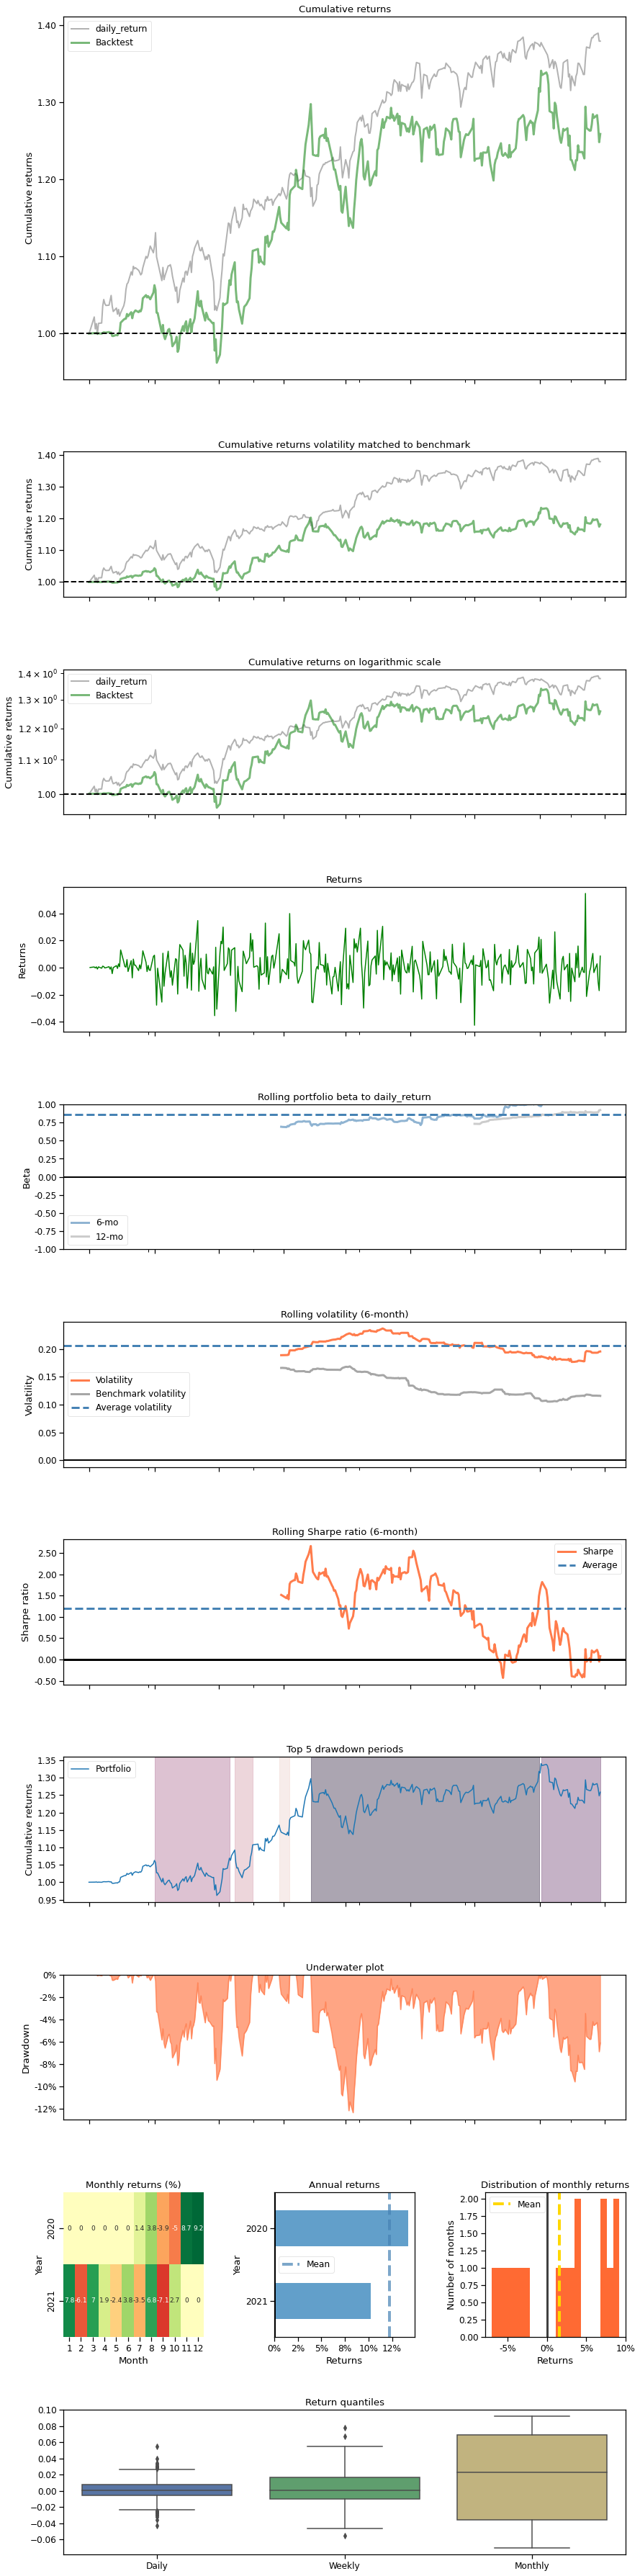

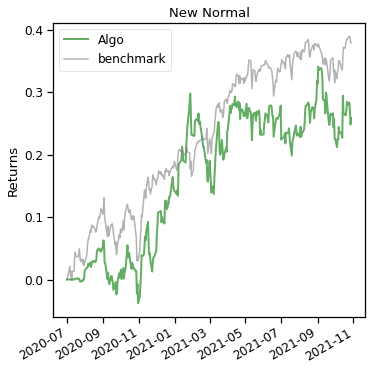

In [28]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value2)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'2.csv')
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value2.loc[0,'date'],
        end = df_account_value2.loc[len(df_account_value2)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value2, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value2.loc[0,'date'],
             baseline_end = df_account_value2.loc[len(df_account_value2)-1,'date'])